In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Nacitanie iris datasetu
# X - features (data)
# y - triedy (setosa, versicolor, virginica)
# Strukturovany dataset (riadky, stlpce)
iris = load_iris()
X = iris.data
y = iris.target

epochs=100

In [3]:
print("Dataset shape:", X.shape)
print("Labels:", set(y))
print("Classes:", iris['target_names'])

iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
iris_df.head()

Dataset shape: (150, 4)
Labels: {0, 1, 2}
Classes: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
# Rozdelenie datasetu na trenovaciu a testovaciu cast (test_size = 0.3 znamena 30% testovacia cast)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
# Vizualizacia datasetu pomocou bodoveho grafu
def create_scatter_plot(X, y, features, title):
    # Set up the figure and axis
    plt.figure(figsize=(12, 10))
    plt.suptitle(title, fontsize=16)

    # Create a scatter plot for each pair of features
    plot_number = 1
    for i in range(len(features)):
        for j in range(len(features)):
            if i < j:
                plt.subplot(2, 3, plot_number)
                for target in np.unique(y):
                    subset = X[y == target]
                    plt.scatter(subset[:, i], subset[:, j], label=iris.target_names[target])
                plt.xlabel(features[i])
                plt.ylabel(features[j])
                plt.legend()
                plot_number += 1

    plt.show()

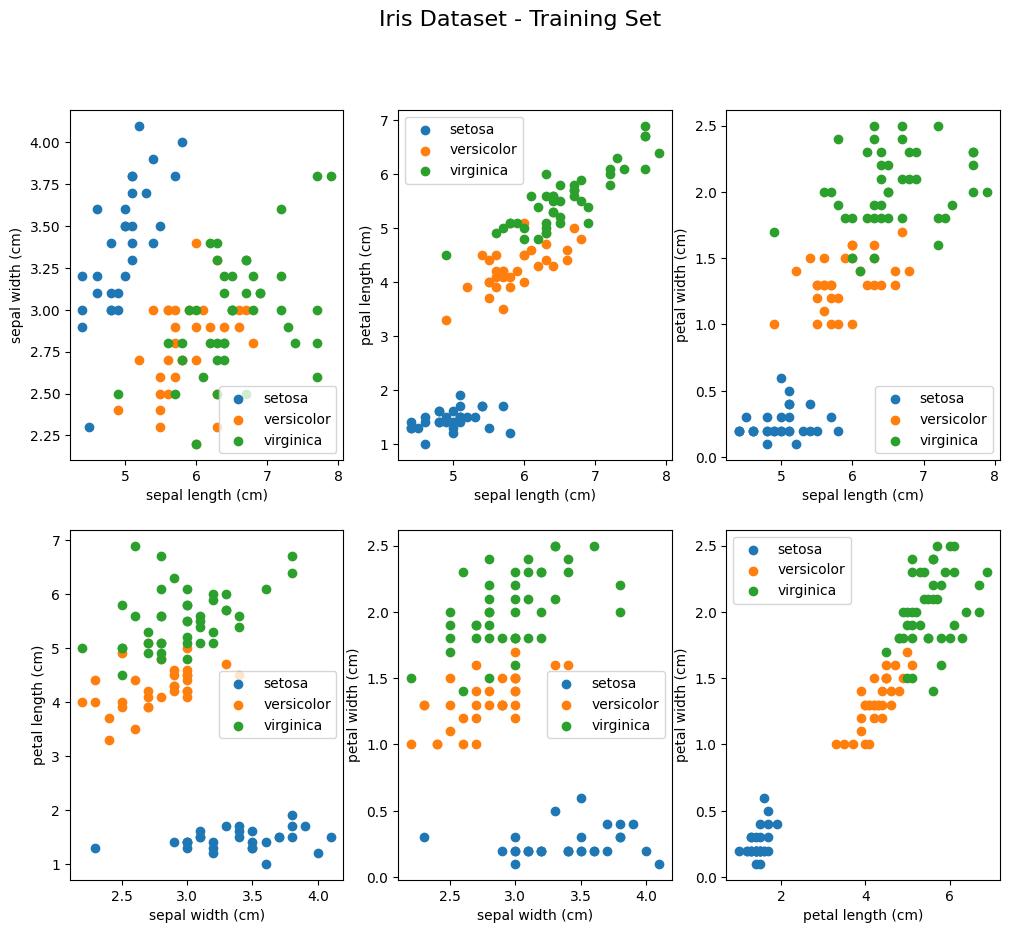

In [6]:
# Vizualizacia trenovacieho setu
create_scatter_plot(X_train, y_train, iris.feature_names, 'Iris Dataset - Training Set')

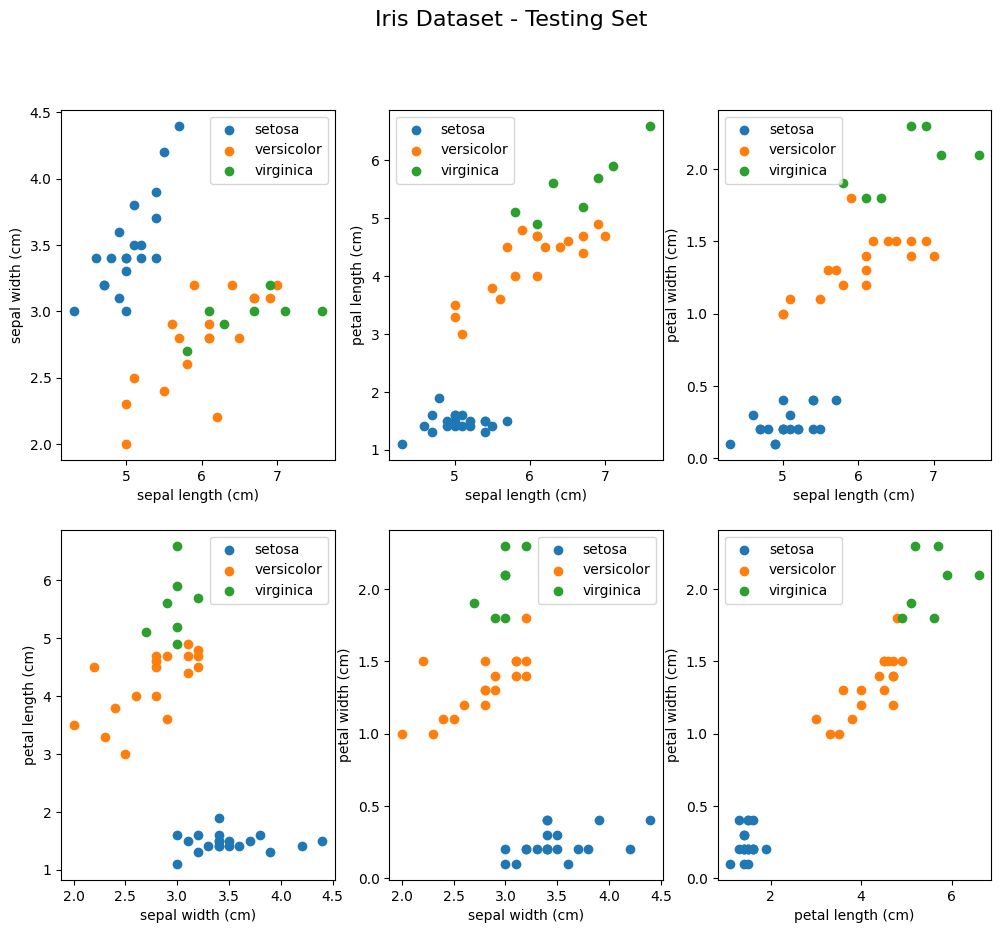

In [7]:
# Vizualizacia testovacieho setu
create_scatter_plot(X_test, y_test, iris.feature_names, 'Iris Dataset - Testing Set')

In [8]:
# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Konvertovanie na tensory
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [10]:
# Vytvorenie dataset objektov
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Vytvorenie loaderov pre loadovanie dat pocas treningu
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [11]:
# MLP Model: Likely to perform well given the simplicity and small size of the Iris dataset. MLPs are generally good for tabular data.
# CNN Model: Might be less effective since the Iris dataset is not image data, and CNNs are primarily designed for spatial data. However, with proper adaptation, it can still perform reasonably well.
# RNN Model: RNNs are designed for sequential data, which the Iris dataset is not. Its performance might be less intuitive and could vary depending on how the input data is structured and fed into the model.

In [12]:
# Definovanie MLP Modelu
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        # 4 input features, 8 neuronov
        self.fc1 = nn.Linear(4, 10)
        # Hidden layer - 10 neuronov
        self.fc2 = nn.Linear(10, 10)
        # output layer, 3 output features
        self.fc3 = nn.Linear(10, 3)

    # Metoda pre predikciu
    def forward(self, x):
        x = self.fc1(x)
        # Aplikovanie relu pre hidder layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
# Definovanie CNN Modelu
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 3)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [14]:
# Definovanie RNN Modelu
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=8, batch_first=True)
        self.fc = nn.Linear(8, 3)

    def forward(self, x):
        x = x.unsqueeze(2)  # Add a feature dimension
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Take the last time step
        x = self.fc(x)
        return x

In [15]:
# Trenovaci loop, pouziva back propagation
def train(model, criterion, optimizer, epoch_number):
    losses_mean = []
    loss_vall_arr = []
    acc_arr = []

    final_epochs = 0
    
    for epoch in range(epoch_number):
        losses = 0
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses += loss.detach().numpy()
            loss.backward()
            optimizer.step()
        # Priemerny loss pre kazdu epochu trenovania
        avg_loss = losses / len(train_loader)
        
        losses_mean.append(avg_loss)

        # Evaluacia pre kazdu epochu, vracia accuracy a loss value
        acc, loss_vall = evaluate_model(model, train_loader)
        acc_arr.append(acc)
        loss_vall_arr.append(loss_vall)
        final_epochs += 1

        print(f'Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {acc}%')

        # Check for consecutive loss increases
        if epoch > 0 and avg_loss > losses_mean[-2]:
            increase_count += 1
            if increase_count >= 3:
                print("Stopping early due to increasing loss.")
                break
        else:
            increase_count = 0  # Reset the counter if loss decreases
        
    return losses_mean, loss_vall_arr, acc_arr, final_epochs

In [16]:
# Funkcia pre vyhodnotenie modelu na testovacich datach
def evaluate_model(model, data_loader):
    model.eval()
    total = 0
    correct = 0
    losses = 0
    losses_mean = []
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses += loss.detach().numpy()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    losses_mean.append(losses/len(train_loader))
    accuracy = 100 * correct / total
    return accuracy, losses_mean

In [17]:
def visualise(loss_vall_arr, acc_arr, epochs):
    epochs = range(0, epochs)
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_vall_arr, label='valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs,acc_arr, label='acc', color = 'orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy %")
    plt.legend()
    plt.tight_layout()
    
    plt.show()

MLP
Epoch 1, Loss: 1.052122617667576, Accuracy: 50.476190476190474%
Epoch 2, Loss: 0.9318437587540105, Accuracy: 61.904761904761905%
Epoch 3, Loss: 0.804149496105482, Accuracy: 67.61904761904762%
Epoch 4, Loss: 0.6806003791543672, Accuracy: 68.57142857142857%
Epoch 5, Loss: 0.6017974037325607, Accuracy: 68.57142857142857%
Epoch 6, Loss: 0.558785653339242, Accuracy: 68.57142857142857%
Epoch 7, Loss: 0.5111310317550065, Accuracy: 68.57142857142857%
Epoch 8, Loss: 0.47702743408252607, Accuracy: 70.47619047619048%
Epoch 9, Loss: 0.4406973451797692, Accuracy: 77.14285714285714%
Epoch 10, Loss: 0.4109710310146494, Accuracy: 81.9047619047619%
Epoch 11, Loss: 0.3793748955259908, Accuracy: 86.66666666666667%
Epoch 12, Loss: 0.34282472518817436, Accuracy: 92.38095238095238%
Epoch 13, Loss: 0.3037064937206934, Accuracy: 94.28571428571429%
Epoch 14, Loss: 0.2666482477677318, Accuracy: 95.23809523809524%
Epoch 15, Loss: 0.2334882147118168, Accuracy: 96.19047619047619%
Epoch 16, Loss: 0.206351260601

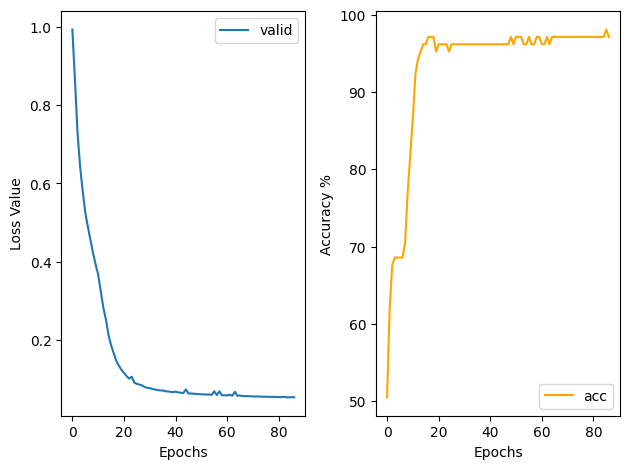

CNN
Epoch 1, Loss: 1.1469067447590378, Accuracy: 32.38095238095238%
Epoch 2, Loss: 0.9962700470438544, Accuracy: 60.95238095238095%
Epoch 3, Loss: 0.8785973106915096, Accuracy: 69.52380952380952%


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch 4, Loss: 0.7840189427699683, Accuracy: 69.52380952380952%
Epoch 5, Loss: 0.7157207350685911, Accuracy: 69.52380952380952%
Epoch 6, Loss: 0.6477216074489197, Accuracy: 71.42857142857143%
Epoch 7, Loss: 0.5971999480476919, Accuracy: 74.28571428571429%
Epoch 8, Loss: 0.5649017407646719, Accuracy: 77.14285714285714%
Epoch 9, Loss: 0.5162258484172371, Accuracy: 80.95238095238095%
Epoch 10, Loss: 0.49418028415936344, Accuracy: 83.80952380952381%
Epoch 11, Loss: 0.4574143699598762, Accuracy: 84.76190476190476%
Epoch 12, Loss: 0.4393345535785522, Accuracy: 85.71428571428571%
Epoch 13, Loss: 0.40952756818173064, Accuracy: 86.66666666666667%
Epoch 14, Loss: 0.3889564689037935, Accuracy: 88.57142857142857%
Epoch 15, Loss: 0.3697983786674603, Accuracy: 88.57142857142857%
Epoch 16, Loss: 0.3516985974010994, Accuracy: 90.47619047619048%
Epoch 17, Loss: 0.3390709346617168, Accuracy: 89.52380952380952%
Epoch 18, Loss: 0.32336374871292206, Accuracy: 90.47619047619048%
Epoch 19, Loss: 0.3064760515

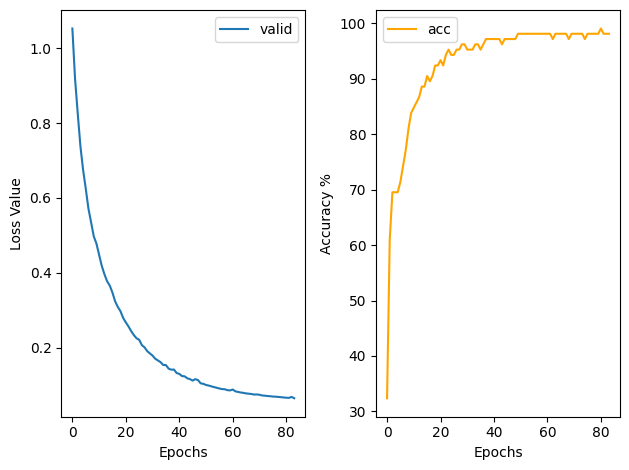

RNN
Epoch 1, Loss: 1.0827932616449751, Accuracy: 30.476190476190474%
Epoch 2, Loss: 1.0566777125844415, Accuracy: 30.476190476190474%
Epoch 3, Loss: 1.0180534079389751, Accuracy: 59.04761904761905%
Epoch 4, Loss: 0.9531683696890777, Accuracy: 84.76190476190476%
Epoch 5, Loss: 0.8565992015712666, Accuracy: 73.33333333333333%
Epoch 6, Loss: 0.7474523389114524, Accuracy: 73.33333333333333%
Epoch 7, Loss: 0.6594527037638538, Accuracy: 74.28571428571429%
Epoch 8, Loss: 0.6051641399005674, Accuracy: 75.23809523809524%
Epoch 9, Loss: 0.5664764457153824, Accuracy: 76.19047619047619%
Epoch 10, Loss: 0.5281760835984968, Accuracy: 80.0%
Epoch 11, Loss: 0.4911416620016098, Accuracy: 81.9047619047619%
Epoch 12, Loss: 0.4512522012557624, Accuracy: 85.71428571428571%
Epoch 13, Loss: 0.4273434031122136, Accuracy: 86.66666666666667%
Epoch 14, Loss: 0.3968256267736543, Accuracy: 90.47619047619048%
Epoch 15, Loss: 0.37628974540615984, Accuracy: 94.28571428571429%
Epoch 16, Loss: 0.3564449384246232, Accur

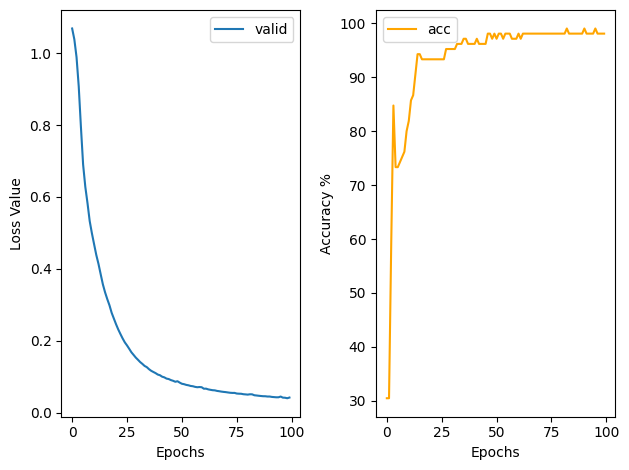

In [18]:
mlp_model = MLPModel()
cnn_model = CNNModel()
rnn_model = RNNModel()

# Definovanie loss funkcie a optimalizatorov
criterion = nn.CrossEntropyLoss()

mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Trenovacie modely
print("MLP")
losses_mean, loss_vall_arr, acc_arr, final_epochs  = train(mlp_model, criterion, mlp_optimizer, epochs)
visualise(loss_vall_arr, acc_arr, final_epochs)
print("CNN")
losses_mean, loss_vall_arr, acc_arr, final_epochs  = train(cnn_model, criterion, cnn_optimizer, epochs)
visualise(loss_vall_arr, acc_arr, final_epochs)
print("RNN")
losses_mean, loss_vall_arr, acc_arr, final_epochs  = train(rnn_model, criterion, rnn_optimizer, epochs)
visualise(loss_vall_arr, acc_arr, final_epochs)

# Evaluacia modelov
#mlp_accuracy = evaluate_model(mlp_model, test_loader)
#cnn_accuracy = evaluate_model(cnn_model, test_loader)
#rnn_accuracy = evaluate_model(rnn_model, test_loader)

In [19]:
def classify_samples(model, tensor):
    # Pass the samples through the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predictions = model(new_samples_tensor)
        _, predicted_classes = torch.max(predictions, 1)
    
    # Print the class names
    for i, index in enumerate(predicted_classes):
        print(f"Sample {i+1}: {iris['target_names'][index]}")

In [20]:
#print(f'MLP Accuracy: {mlp_accuracy}%')
#print(f'CNN Accuracy: {cnn_accuracy}%')
#print(f'RNN Accuracy: {rnn_accuracy}%')
print("================================")

# Testuje nové vzorky na MLP modeli, transformuje ich, konvertuje na tenzory, predpovedá triedy a vypisuje názvy predpovedaných tried

new_samples = np.array([
    [5.1, 3.5, 1.4, 0.2],
    [6.7, 3.0, 5.2, 2.3],
    [5.9, 3.0, 4.2, 1.5],
    [6.1, 2.9, 4.7, 1.4],
    [4.6, 3.4, 1.4, 0.3]
])

# Scale the samples
new_samples_scaled = scaler.transform(new_samples)

# Konvertovanie na tensor
new_samples_tensor = torch.tensor(new_samples_scaled, dtype=torch.float32)

print("MLP")
classify_samples(mlp_model, new_samples_tensor)
print("CNN")
classify_samples(cnn_model, new_samples_tensor)
print("RNN")
classify_samples(rnn_model, new_samples_tensor)

MLP
Sample 1: setosa
Sample 2: virginica
Sample 3: versicolor
Sample 4: versicolor
Sample 5: setosa
CNN
Sample 1: setosa
Sample 2: virginica
Sample 3: versicolor
Sample 4: versicolor
Sample 5: setosa
RNN
Sample 1: setosa
Sample 2: virginica
Sample 3: versicolor
Sample 4: versicolor
Sample 5: setosa
